# Import and Function Definition

In [1]:
# %matplotlib widget #To give ineractive plots, comment out if getting errors
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Define functions
def GenEllipse(θ,a,b):
    ''' Generate ellipse profile
    '''
    r = np.sqrt(1/((np.cos(np.deg2rad(θ))/a)**2+(np.sin(np.deg2rad(θ))/b)**2))
    return r

#Get ramp vector
def RampVec(θ,ramp_start,ramp_angle,doc):
    ramp_vector = np.zeros(np.size(θ)) #Intialize ramp vector
    ramp_vector[np.logical_and(θ>=ramp_start, θ<=ramp_start+ramp_angle)] = -θ[θ<=ramp_angle]/ramp_angle*doc #ramp vector to give feed gradually
    return ramp_vector

def EllipseRamp(θ,r,ramp_vector):
    return r-ramp_vector

def GenCutEllipseParams(θ,a_initial,a_final,b_initial,b_final,doc):
    doca = (a_initial-a_final)/np.ceil((a_initial-a_final)/doc)
    docb = (b_initial-b_final)/np.ceil((b_initial-b_final)/doc)

    num_revs = int(max(np.ceil((a_initial-a_final)/doc),np.ceil((b_initial-b_final)/doc)))+1
    a_vector = np.linspace(a_initial,a_final,num_revs)
    b_vector = np.linspace(b_initial,b_final,num_revs)

    l_stroke = abs(a_vector-b_vector)

    return doca, a_vector, docb, b_vector, num_revs, l_stroke

def GenCutProfile(θ, a_initial, a_final, b_initial, b_final, doc, r_wheel):
    doca, a_vector, docb, b_vector, num_revs, l_stroke = GenCutEllipseParams(θ,a_initial,a_final,b_initial,b_final,doc);
    CR_vector = np.zeros([num_revs*len(θ),2])
    X_vector = np.zeros(num_revs*len(θ))

    for i in range(num_revs):
        a = a_vector[i]
        b = b_vector[i]
#         print(a,b)
        r = GenEllipse(θ,a,b); #[mm] Radial profile of ellipse
#         print(r)
        CR_vector[i*len(θ):(i+1)*len(θ),0] = i*360+θ
        CR_vector[i*len(θ):(i+1)*len(θ),1] = r
        X_vector[i*len(θ):(i+1)*len(θ)] = GenWheelOffset(θ,Polar2Cart(CR_vector[i*len(θ):(i+1)*len(θ),0], CR_vector[i*len(θ):(i+1)*len(θ),1]),a,b,r_wheel) #Get the wheel offset!
    
    #add last element for completion
    last_element = np.diff(CR_vector[i*len(θ):(i)*len(θ)+2,:],axis=-2)
    last_element[0,1] = -last_element[0,1]
    CR_vector = np.vstack((CR_vector,CR_vector[-1,:]+last_element))
    
    last_element_X = GenWheelOffset(θ,Polar2Cart(CR_vector[-1,0], CR_vector[-1,1]),a,b,r_wheel) #Get the wheel offset!
    X_vector = np.hstack((X_vector,last_element_X))
    
    return doca, a_vector, docb, b_vector, num_revs, l_stroke, CR_vector, X_vector

def GenWheelOffset(θ,xy,a,b,r_wheel):
    #Find position of wheel center from the work center for the ellipse profile
    x=xy[:,0]
    y=xy[:,1]
    n = np.vstack(((b**2)*x,(a**2)*y)).T ; #Normal vector to each X,Y point based on equation of normal to an ellipse 
                                       # https://www.emathzone.com/tutorials/geometry/equation-of-tangent-and-normal-to-ellipse.html
    n̂ = normalized(n) ; #Normalized n vector
    Wo = xy + n̂*r_wheel #[mm,mm] Coordinates of the wheel center relative to x,y
    X = np.linalg.norm(Wo, ord=2, axis=-1) #Wheel center distance from work ceter distance
    return X

def GenWheelMotionProfile(θ, aw_initial, aw_final, bw_initial, bw_final, doc, r_wheel):
    '''Generate the CX profiles such that the CX motion traces a pure ellipse. 
    Also find the coordinates representing the shape of the component.
    
    #If wheel moves sinusoidal, then what shape does it cut?
    Key idea is that we not the normal to the curve of the wheel centers with respect to the component center. 
    Draw a normal to the curve of wheel centers and then go a distance equal to the wheel radius along the normal 
    (on the inside of the curve of the wheel centers)
    The intersection point will be a point on the component - (Px,Py).
    '''
    doca, a_vector, docb, b_vector, num_revs, l_stroke = GenCutEllipseParams(θ,aw_initial,aw_final,bw_initial,bw_final,doc)
    CX_vector = np.zeros([num_revs*len(θ),2])
    comp_profile_xy = np.zeros(([num_revs*len(θ),2]))
    
    for i in range(num_revs):
        a = a_vector[i]
        b = b_vector[i]
    #     print(a,b)
        r = GenEllipse(θ,a,b); #[mm] Radial profile of ellipse
    #     print(r)
        CX_vector[i*len(θ):(i+1)*len(θ),0] = i*360+θ
        CX_vector[i*len(θ):(i+1)*len(θ),1] = r
        comp_profile_xy[i*len(θ):(i+1)*len(θ),:] = FindCompCoords(θ,CX_vector[i*len(θ):(i+1)*len(θ),:],a,b,r_wheel)
    
    #add last element for completion
    last_element = np.diff(CX_vector[i*len(θ):(i)*len(θ)+2,:],axis=-2)
    last_element[0,1] = -last_element[0,1]
    CX_vector = np.vstack((CX_vector,CX_vector[-1,:]+last_element))
    
    last_element_xy = FindCompCoords(θ,[CX_vector[-1,:]],a,b,r_wheel) #Get the wheel offset!
    X_vector = np.vstack((comp_profile_xy,last_element_xy))
    
    return doca, a_vector, docb, b_vector, num_revs, l_stroke, CX_vector, comp_profile_xy

def FindCompCoords(θ,CX_vector,aw,bw,r_wheel):
    CX_vector = np.asarray(CX_vector)
    Wxy = Polar2Cart(CX_vector[:,0],CX_vector[:,1])
    Wx = Wxy[:,0]
    Wy = Wxy[:,1]
    n_w = np.vstack((((bw)**2)*Wx,((aw)**2)*Wy)).T ; #Normal vector to each X,Y point based on equation of normal to an ellipse 
                                       # https://www.emathzone.com/tutorials/geometry/equation-of-tangent-and-normal-to-ellipse.html
    n̂_w = normalized(n_w) ; #Normalized n vector
    Cxy = Wxy-n̂_w*r_wheel; #Component coordinates- negative as want to go on the inside
    return Cxy

def Polar2Cart(θ,r):
    θ = np.asarray(θ)
    r = np.asarray(r)
    xy = np.zeros([np.size(θ),2])
    xy[:,0] = r*np.cos(np.deg2rad(θ)) #profile x coordinate
    xy[:,1] = r*np.sin(np.deg2rad(θ)) #profile y coordinate
    return xy

def Cart2Polar(x,y):
    """Convert cartesian to polar coordinates
    """
    x = np.asarray(x)
    y = np.asarray(y)
    rθ = np.zeros([len(x),2])
    rθ[:,0] = np.sqrt(x**2+y**2)
    rθ[:,1] = np.arctan2(y,x)
    rθ[:,1] = (rθ[:,1] + 2*np.pi) % (2 * np.pi ) # Convert from -π,π to 0,2π range
    rθ[:,1] = np.rad2deg(rθ[:,1]) #Convert to degrees
    return rθ

def normalized(a, axis=-1, order=2):
    #Normalize a vector
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

# Initialization

In [3]:
#Define params
θ_step = 0.2
θ = np.arange(0,360,θ_step)

N_work = 10 #[rpm] work-speed
π = np.pi
ω_work = 2*π*N_work/60 #[rad/s] work-speed

a_initial = 49.5
a_final = 49.5

b_initial = 48.5
b_final = 29 #Leaving atleast 1 mm stock!

doc = 5; #0.12 ; #[mm] depth of cut (max), per revolution
#To see what the code is doing, increase doc to 10 mm.

d_wheel = 400 ;#[mm] wheel diameter
r_wheel = d_wheel/2 ;#[mm] wheel radius

#Generate coordinate for wheel-offset ellipse (If we cut in this shape, CX motions are sinusoidal, 
#component profile is not a pure ellipse, but don't care so much for roughing)
aw_initial = r_wheel+a_initial;
aw_final = r_wheel+a_initial;

bw_initial = r_wheel+b_initial;
bw_final = r_wheel+b_final;

# Direct CX - Profile generation with wheel offset considerations

In [4]:
#Generate Wheel motion profile
doca, a_vector, docb, b_vector, num_revs, l_stroke, CX_vector, comp_profile_xy = GenWheelMotionProfile(θ, aw_initial, aw_final, bw_initial, bw_final, doc, r_wheel)

#Generate C_inc, X_inc codes for the machine coordinates
C_inc_vector = np.hstack((0,np.diff(CX_vector[:,0])))
X_inc_vector = np.hstack((0,np.diff(CX_vector[:,1])))

C:\Users\Brij\Miniconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


Depth of cut (max): 4875.00 μm/rev
# of work-revs: 5


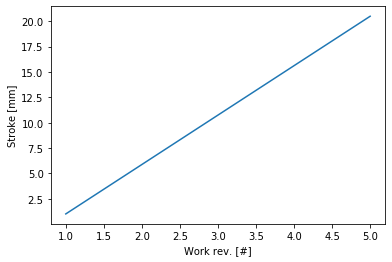

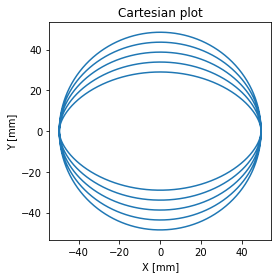

In [5]:
print("Depth of cut (max): {:.2f} μm/rev".format(docb*1000))
print("# of work-revs: {:d}".format(num_revs))

plt.plot(range(1,num_revs+1),l_stroke);plt.xlabel('Work rev. [#]');plt.ylabel('Stroke [mm]');


plt.figure();
plt.plot(comp_profile_xy[:,0],comp_profile_xy[:,1])
plt.gca().set_aspect('equal', adjustable='box');
plt.title('Cartesian plot');plt.xlabel('X [mm]');
plt.ylabel('Y [mm]');

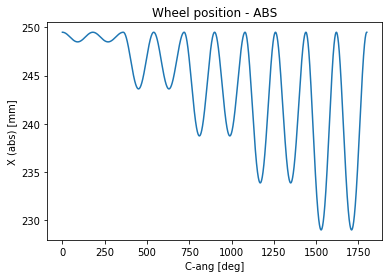

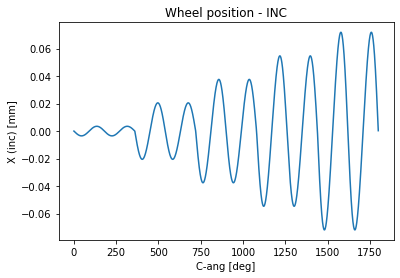

In [6]:
#Plot motion coordinates
plt.figure();
plt.plot(CX_vector[:,0],CX_vector[:,1]) #[mm] abs X - wheel center position
plt.xlabel('C-ang [deg]')
plt.ylabel('X (abs) [mm]')
plt.title('Wheel position - ABS')

plt.figure();
plt.plot(CX_vector[:,0],X_inc_vector) #[mm] inc X - wheel center position
plt.xlabel('C-ang [deg]')
plt.ylabel('X (inc) [mm]')
plt.title('Wheel position - INC');

In [7]:
#Save CX-Array - work angle, X-position (incremental)
# np.savetxt('CX_inc_5mm_doc.txt',)
f = open("CX_WheelINC_5mm_doc.txt", "w")
for i in range(len(C_inc_vector)):
    f.write('C{:.6f}\tX{:.6f}\n'.format(C_inc_vector[i],X_inc_vector[i])) #each line, can directly copy into G Code! Make sure to use G21, G91 before running this code
#     f.write('{:10.6f},{:10.6f}\n'.format(C_inc_vector[i],X_inc_vector[i])) #For testing, can plot easily in excel without C, X chars
#     f.write('C{:.6f}\tX{:.6f}\n'.format(CR_vector[i,0],X_vector[i])) #Also for testing
f.close();#Close handle to file once saved

# [Extra] Wheel-wear vs. cycle time

Nw = work-rpm

S = stock [mm]

d = depth of cut [mm/rev]

r_max = max. component radius [mm]

t = time taken [min]

$MRR' = 2 \pi \cdot N_w \cdot d \cdot r_{max} $ ; Thus, MRR' should be below a certain limit, can be higher for creep-feed grinding mode to minimize wheel wear

$ t = \frac{S}{d \cdot N_w}$, Time taken for grinding. To minimize time, we need to maximize the product of $d \cdot N_w$ but limiting MRR' limits that!

Therefore, fix MRR' and the maximum work surface speed (fix Nw) we want to run and select the doc based on that to give the MRR'.

Should also probably consider the chip-thickness.

# Component profile generation and then take wheel offset

C:\Users\Brij\Miniconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


Depth of cut (max): 4875.00 μm/rev
# of work-revs: 5


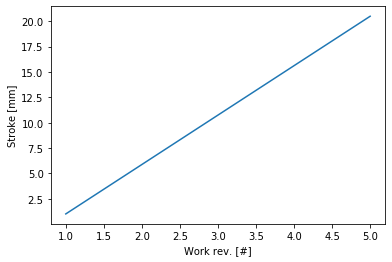

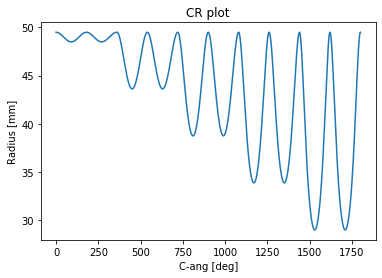

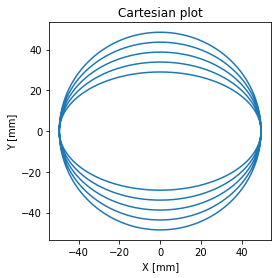

In [8]:
# Generate the CR profile for roughing
doca, a_vector, docb, b_vector, num_revs, l_stroke, CR_vector, X_vector = GenCutProfile(θ, a_initial, a_final, b_initial, b_final, doc, r_wheel)
# last_element = np.diff(CR_vector[0:2,:],axis=-2)
# last_element[0,1] = -last_element[0,1]

# CR_vector = np.vstack((CR_vector,CR_vector[-1,:]+last_element))

np.savetxt('CR_5mm_doc.txt',CR_vector, delimiter=',', fmt='%10.6f')   # Save C,R array (work-angle, radius) use exponential notation

print("Depth of cut (max): {:.2f} μm/rev".format(docb*1000))
print("# of work-revs: {:d}".format(num_revs))
plt.plot(range(1,num_revs+1),l_stroke);plt.xlabel('Work rev. [#]');plt.ylabel('Stroke [mm]');
plt.figure();plt.plot(CR_vector[:,0],CR_vector[:,1]);plt.title('CR plot');plt.xlabel('C-ang [deg]');plt.ylabel('Radius [mm]');
XY_vector=Polar2Cart(CR_vector[:,0],CR_vector[:,1])
plt.figure();plt.plot(XY_vector[:,0],XY_vector[:,1]);plt.gca().set_aspect('equal', adjustable='box');plt.title('Cartesian plot');plt.xlabel('X [mm]');plt.ylabel('Y [mm]');

In [9]:
#Generate C_inc, X_inc codes for the machine coordinates
C_inc_vector = np.hstack((0,np.diff(CR_vector[:,0])))
X_inc_vector = np.hstack((0,np.diff(X_vector)))

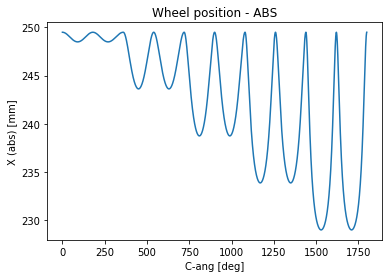

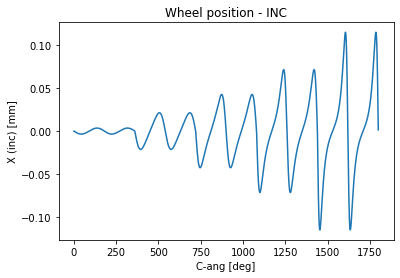

In [10]:
#Plot coordinates
plt.figure();
plt.plot(CR_vector[:,0],X_vector) #[mm] abs X - wheel center position
plt.xlabel('C-ang [deg]')
plt.ylabel('X (abs) [mm]')
plt.title('Wheel position - ABS')

plt.figure();
plt.plot(CR_vector[:,0],X_inc_vector) #[mm] inc X - wheel center position
plt.xlabel('C-ang [deg]')
plt.ylabel('X (inc) [mm]')
plt.title('Wheel position - INC');

In [11]:
#Save CX-Array - work angle, X-position (incremental)
# np.savetxt('CX_inc_5mm_doc.txt',)
f = open("CX_inc_5mm_doc.txt", "w")
for i in range(len(C_inc_vector)):
    f.write('C{:.6f}\tX{:.6f}\n'.format(C_inc_vector[i],X_inc_vector[i])) #each line, can directly copy into G Code! Make sure to use G21, G91 before running this code
#     f.write('{:10.6f},{:10.6f}\n'.format(C_inc_vector[i],X_inc_vector[i])) #For testing, can plot easily in excel without C, X chars
#     f.write('C{:.6f}\tX{:.6f}\n'.format(CR_vector[i,0],X_vector[i]))
f.close();#Close handle to file once saved

# Characterisitic features of elliptical profile - code details

In [12]:
a = 49.5 #r_wheel+ #minor radius
b = 29 # r_wheel+ #major radius

In [13]:
# r = np.sqrt(1/((np.cos(np.deg2rad(θ))/a)**2+(np.sin(np.deg2rad(θ))/b)**2))
r = GenEllipse(θ,a,b); #[mm] Radial profile of ellipse
ṙ = np.gradient(r,θ,edge_order=2) #velcoity
r̈ = np.gradient(ṙ,θ,edge_order=2) #acceleration
r⃛ = np.gradient(r̈,θ,edge_order=1) #jerk

Smooth acceleration, velocity and jerk profiles


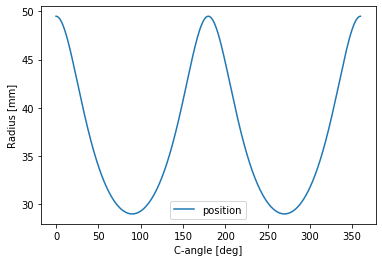

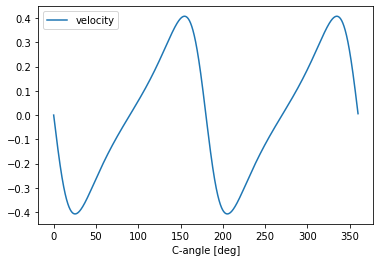

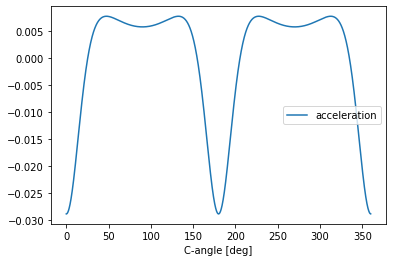

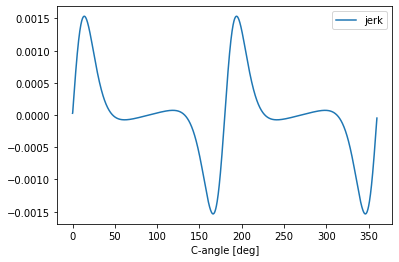

In [14]:
#Plot θVAJ for profile
print("Smooth acceleration, velocity and jerk profiles")
plt.figure()
plt.plot(θ,r,label="position"); plt.legend(); plt.xlabel('C-angle [deg]');plt.ylabel('Radius [mm]')
plt.figure()
plt.plot(θ,ṙ,label="velocity"); plt.legend();plt.xlabel('C-angle [deg]')
plt.figure()
plt.plot(θ,r̈,label="acceleration"); plt.legend();plt.xlabel('C-angle [deg]')
plt.figure()
plt.plot(θ,r⃛,label="jerk"); plt.legend();plt.xlabel('C-angle [deg]');

Max interpolation error: 0.144258 μm


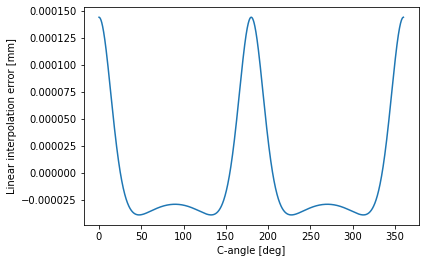

In [15]:
#interpolation error 
#linear as we use G01 command 
#Can be made better if we use G02/G03 command

#Find the mid point acual value between two points and then compare with the avarage radius from the current profile.
θ1 = np.arange(θ_step/2,360,θ_step) #offset and find new theta in between original θ vector
r1 = np.sqrt(1/((np.cos(np.deg2rad(θ1))/a)**2+(np.sin(np.deg2rad(θ1))/b)**2)) #Find the actual value at that location
r_mean_interp = (np.roll(r,-1)+r)/2 #Find average of the radius between two points in the original r-vector
interp_error = r1-r_mean_interp #interpolation error is maximum at the mid-point 

print("Max interpolation error: {:f} μm".format(max(abs(interp_error*1e3))))
plt.plot(θ1,interp_error);plt.xlabel('C-angle [deg]');plt.ylabel('Linear interpolation error [mm]');

In [16]:
x = r*np.cos(np.deg2rad(θ)) #profile x coordinate
y = r*np.sin(np.deg2rad(θ)) #profile y coordinate
xy = np.vstack((x,y)).T ; #xy array
n = np.vstack(((b**2)*x,(a**2)*y)).T ; #Normal vector to each X,Y point based on equation of normal to an ellipse 
                                       # https://www.emathzone.com/tutorials/geometry/equation-of-tangent-and-normal-to-ellipse.html
n̂ = normalized(n) ; #Normalized n vector

In [17]:
Wo = xy + n̂*r_wheel #[mm,mm] Coordinates of the wheel center relative to x,y
X = np.linalg.norm(Wo, ord=2, axis=-1) #Wheel center distance from work ceter distance
X_inc = np.hstack((0,np.diff(X)))
θ_inc = np.hstack((0,np.diff(θ)))
# n̂; Wo; X_inc; X
# np.savetxt('test.csv',X_inc)
# Wo.reshape(1800,2).tolist()
# GenWheelOffset(θ,xy,a,b,r_wheel); #To compare with above tool offset

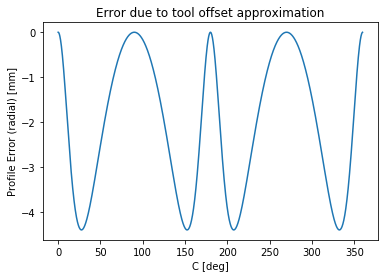

In [18]:
err_appx = X-(r+r_wheel) #[mm] error compared to just adding wheel radius to component radius
plt.plot(θ,err_appx)
plt.title('Error due to tool offset approximation')
plt.xlabel('C [deg]')
plt.ylabel('Profile Error (radial) [mm]');

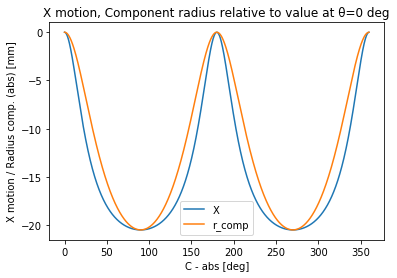

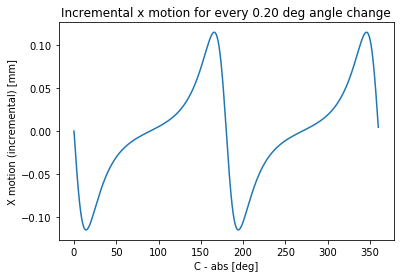

In [19]:
#Plots for wheel motion
plt.figure(); plt.plot(θ,X-X[0],label='X'); 
plt.plot(θ,r-r[0],label='r_comp')
# plt.subplot(2,1,2)
# plt.plot(θ[1:],θ_inc)
plt.legend()
plt.title('X motion, Component radius relative to value at θ=0 deg'.format(θ_step))
plt.xlabel('C - abs [deg]')
plt.ylabel('X motion / Radius comp. (abs) [mm]');

# plt.subplot(2,1,1); 
plt.figure();
plt.plot(θ,X_inc)
# plt.subplot(2,1,2)
# plt.plot(θ[1:],θ_inc)
plt.title('Incremental x motion for every {:.2f} deg angle change'.format(θ_step))
plt.xlabel('C - abs [deg]')
plt.ylabel('X motion (incremental) [mm]');

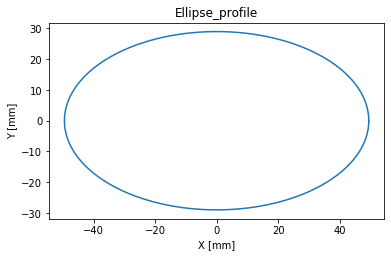

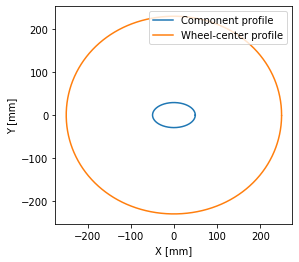

In [20]:
plt.figure()
plt.plot(xy[:,0],xy[:,1],label='Component profile')
plt.title('Ellipse_profile')
plt.xlabel('X [mm]')
plt.ylabel('Y [mm]')
plt.gca().set_aspect('equal', adjustable='box')

plt.figure()
plt.plot(xy[:,0],xy[:,1],label='Component profile')
plt.plot(Wo[:,0],Wo[:,1], label='Wheel-center profile')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
# plt.title('Ellipse_profile')
plt.xlabel('X [mm]')
plt.ylabel('Y [mm]')
# plt.show()
# plt.grid()
plt.savefig('test.svg',bbox_inches='tight');

# plt.figure()
# plt.plot(Polar2Cart(θ,X)[:,0],Polar2Cart(θ,X)[:,1],label='Wheel center (rel.)') #Remove the wheel radius from the motion of the wheel
# plt.plot(xy[:,0],xy[:,1],label='Component profile')
# plt.plot(Wo[:,0],Wo[:,1], label='Wheel-center profile')
# # plt.plot(Wo[:,0],Wo[:,1], label='Wheel-center profile')
# plt.gca().set_aspect('equal', adjustable='box')
# plt.legend()
# # plt.title('Ellipse_profile')
# plt.xlabel('X [mm]')
# plt.ylabel('Y [mm]')
# plt.show()

In [21]:
#Surface velocity
v_surface = ω_work*r*60 #[mm/min]

#depth of cut
doca, a_vector, docb, b_vector, num_revs, l_stroke, CR_vector, X_vector = GenCutProfile(θ, a, a, b+3*doc, b, doc, r_wheel)
docAng = CR_vector[2*len(θ):(3)*len(θ),1] - CR_vector[3*len(θ):(4)*len(θ),1] #[mm] radial depth of cut 
print(doca,num_revs)

#MRR'
Q_prime = docAng*v_surface #[mm^2/min]

nan 4


C:\Users\Brij\Miniconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


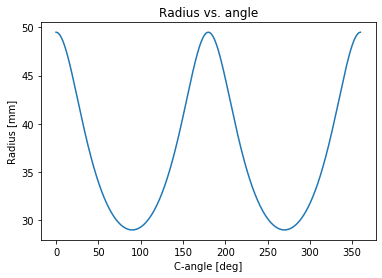

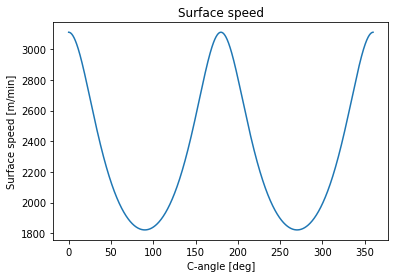

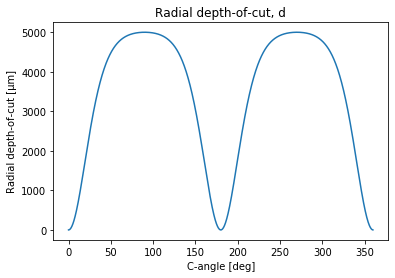

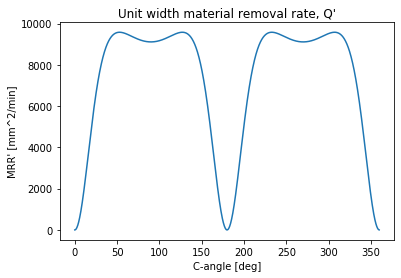

In [22]:
plt.figure()
plt.plot(θ,r); plt.xlabel('C-angle [deg]');plt.ylabel('Radius [mm]');plt.title('Radius vs. angle')
plt.figure()
plt.plot(θ,v_surface);plt.xlabel('C-angle [deg]');plt.ylabel('Surface speed [m/min]'); plt.title('Surface speed');
plt.figure()
plt.plot(θ,docAng*1e3);plt.xlabel('C-angle [deg]');plt.ylabel('Radial depth-of-cut [μm]'); plt.title('Radial depth-of-cut, d');
plt.figure()
plt.plot(θ,Q_prime);plt.xlabel('C-angle [deg]');plt.ylabel('MRR\' [mm^2/min]'); plt.title('Unit width material removal rate, Q\'');

# Sandbox Code, not used

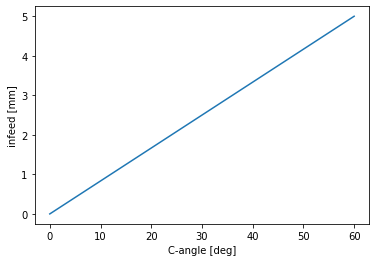

In [23]:
# For ramping the depth of cut
ramp_start = 50 #[deg] Ramp start angle
ramp_angle = 60 #[deg] Ramp angle
ramp_vector = θ[θ<=ramp_angle]/ramp_angle*doc #ramp vector to give feed gradually
plt.plot(θ[θ<=ramp_angle],ramp_vector); plt.xlabel('C-angle [deg]');plt.ylabel('infeed [mm]');

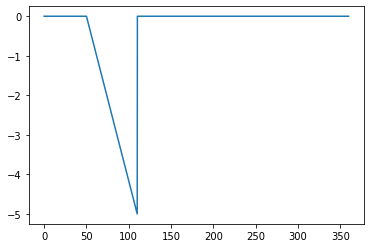

In [24]:
γ = RampVec(θ,ramp_start,ramp_angle,doc)
plt.plot(θ,γ)

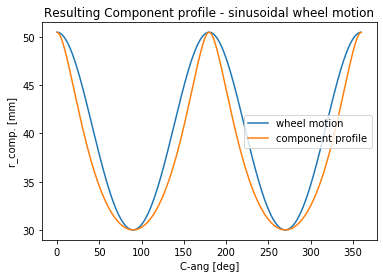

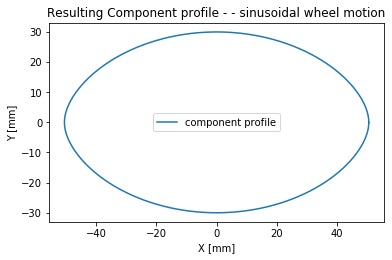

In [25]:
#If wheel moves sinusoidal, then what shape does it cut?
''' Key idea is that we not the normal to the curve of the wheel centers with respect to the component center. 
Draw a normal to the curve of wheel centers and then go a distance equal to the wheel radius along the normal (on the inside of the curve of the wheel centers)
The intersection point will be a point on the component - (Px,Py).
'''

X_test = GenEllipse(θ,a+r_wheel+1,b+r_wheel+1) #r_wheel + r;
Wxy = Polar2Cart(θ,X_test)
Wx = Wxy[:,0]
Wy = Wxy[:,1]
n_w = np.vstack((((r_wheel+b)**2)*Wx,((r_wheel+a)**2)*Wy)).T ; #Normal vector to each X,Y point based on equation of normal to an ellipse 
                                       # https://www.emathzone.com/tutorials/geometry/equation-of-tangent-and-normal-to-ellipse.html
n̂_w = normalized(n_w) ; #Normalized n vector
Cxy = Wxy-n̂_w*r_wheel; #Component coordinates- negative as want to go on the inside

Crθ = Cart2Polar(Cxy[:,0],Cxy[:,1])

# plt.plot(θ,meh)
plt.figure
plt.title('Resulting Component profile - sinusoidal wheel motion')
plt.plot(θ,X_test-r_wheel,label='wheel motion') #Wheel motion
plt.plot(Crθ[:,1],Crθ[:,0],label='component profile')
plt.legend()
plt.xlabel('C-ang [deg]')
plt.ylabel('r_comp. [mm]')


plt.figure(); 
# plt.plot(Polar2Cart(θ,r)[:,0],Polar2Cart(θ,r)[:,1],label='wheel motion')
plt.plot(Cxy[:,0],Cxy[:,1],label='component profile')
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Resulting Component profile - - sinusoidal wheel motion')
plt.xlabel('X [mm]')
plt.ylabel('Y [mm]')
plt.legend();